In [23]:
import argparse
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
from models.GTM_POP import GTM
from utils.data import POPDataset
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from pathlib import Path
from PIL import Image
import torchvision.transforms as T

In [2]:
def cal_error_metrics(gt, forecasts):
    # Absolute errors
    mae = mean_absolute_error(gt, forecasts)
    wape = 100 * np.sum(np.sum(np.abs(gt - forecasts), axis=-1)) / np.sum(gt)

    return round(mae, 3), round(wape, 3)

In [38]:
def get_key_from_dict(dict , vals):
    # list out keys and values separately
    key_list = list(dict.keys())
    val_list = list(dict.values())
     
    # Get key with val 
    keys = []
    keys.append(key_list[val_list.index(vals)])
    return keys

In [40]:
def print_error_metrics(y_test, y_hat, rescaled_y_test, rescaled_y_hat):
    mae, wape = cal_error_metrics(y_test, y_hat)
    rescaled_mae, rescaled_wape = cal_error_metrics(rescaled_y_test, rescaled_y_hat)
    print("MAE: ", mae, "\nWAPE: ", wape, "\nRescaled MAE:",rescaled_mae,"\nRescaled WAPE:", rescaled_wape)

    # plot lines
    plt.plot(rescaled_y_test[0], label = "GTrends")
    plt.plot(rescaled_y_hat[0], label = "POP Prediction")
    plt.xlabel('Weeks')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [9]:
class Args():
    def __init__(self):
        self.data_folder = 'dataset/'
        self.ckpt_path = 'log/path-to-model.ckpt'
        self.gpu_num = 0
        self.seed = 21
        self.img_root = 'dataset/images/'
        self.pop_path = 'signals/pop.pt'
    
        self.model_type = 'GTM'
        self.use_trends = 1
        self.use_img = 1
        self.use_text = 1
        self.trend_len = 52
        self.num_trends = 1
        self.embedding_dim =32 
        self.hidden_dim = 64
        self.output_dim = 12
        self.use_encoder_mask =1
        self.autoregressive = 0
        self.num_attn_heads = 4
        self.num_hidden_layers = 1
        self.decoder_input_type = 3
    
        self.wandb_run = 'Run1'

In [10]:
args = Args()

In [11]:
# Set up CUDA
device = torch.device(f'cuda:{args.gpu_num}' if torch.cuda.is_available() else 'cpu')

# Seeds for reproducibility
pl.seed_everything(args.seed)

# Load sales data    
test_df = pd.read_csv(Path(args.data_folder + 'test.csv'), parse_dates=['release_date'])
item_codes = test_df['external_code'].values

 # Load category and color encodings
cat_dict = torch.load(Path(args.data_folder + 'category_labels.pt'))
col_dict = torch.load(Path(args.data_folder + 'color_labels.pt'))
fab_dict = torch.load(Path(args.data_folder + 'fabric_labels.pt'))

pop_signal = torch.load(args.pop_path)

test_loader = POPDataset(test_df, args.img_root, pop_signal, cat_dict, col_dict, \
        fab_dict, args.trend_len).get_loader(batch_size=1, train=False)


model_savename = f'{args.wandb_run}_{args.output_dim}'

Global seed set to 21


Starting dataset creation process...


100%|#########################################| 497/497 [00:08<00:00, 55.53it/s]


Done.


In [12]:
# Create model
model = GTM(
        embedding_dim=args.embedding_dim,
        hidden_dim=args.hidden_dim,
        output_dim=12,
        num_heads=args.num_attn_heads,
        num_layers=args.num_hidden_layers,
        cat_dict=cat_dict,
        col_dict=col_dict,
        fab_dict=fab_dict,
        trend_len=args.trend_len, 
        num_trends= args.num_trends,
        decoder_input_type=args.decoder_input_type,
        use_encoder_mask=args.use_encoder_mask,
        autoregressive=args.autoregressive,
        gpu_num=args.gpu_num
)

#model.load_state_dict(torch.load(args.ckpt_path)['state_dict'], strict=False)

/Users/irshad/Dev/PyEnv/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/irshad/Dev/PyEnv/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
# Forecast the testing set
model.to(device)
model.eval()
gt, forecasts, attns = [], [],[]
for test_data in tqdm(test_loader, total=len(test_loader), ascii=True):
    with torch.no_grad():
        test_data = [tensor.to(device) for tensor in test_data]
        item_sales, attrs, temporal_features, pop_signal, images =  test_data
        #print(item_sales.shape , "\n" , attrs.shape, "\n" ,temporal_features.shape, "\n" ,pop_signal.shape, "\n" ,images.shape)
        y_pred, att = model(attrs, temporal_features, pop_signal, images)
        forecasts.append(y_pred.detach().cpu().numpy().flatten()[:args.output_dim])
        gt.append(item_sales.detach().cpu().numpy().flatten()[:args.output_dim])
        attns.append(att.detach().cpu().numpy())

100%|#########################################| 497/497 [00:43<00:00, 11.46it/s]


MAE:  0.568 
WAPE:  1170.974 
Rescaled MAE: 604.807 
Rescaled WAPE: 1170.974


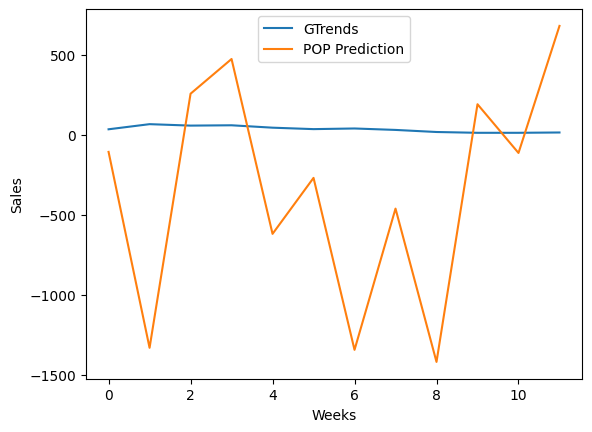

In [48]:
attns = np.stack(attns)
forecasts = np.array(forecasts)
gt = np.array(gt)

rescale_vals = np.load(args.data_folder + 'normalization_scale.npy')
rescaled_forecasts = forecasts * rescale_vals
rescaled_gt = gt * rescale_vals
print_error_metrics(gt, forecasts, rescaled_gt, rescaled_forecasts)


torch.save({'results': forecasts* rescale_vals, 'gts': gt* rescale_vals, 'codes': item_codes.tolist()}, Path('results/' + model_savename+'.pth'))

Category:  ['trapeze dress']
Color:  ['blue']
Texture:  ['milano stitch']


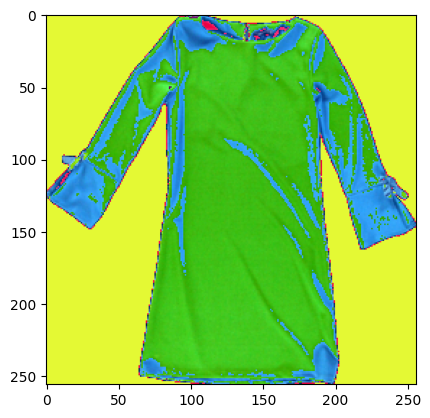

In [46]:
# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
img = transform(images[0])

plt.imshow(img)

print("Category: ",get_key_from_dict(cat_dict, [attrs[0][0]]))
print("Color: ",get_key_from_dict(col_dict, attrs[0][2]))
print("Texture: ",get_key_from_dict(fab_dict, [attrs[0][1]]))
